In [ ]:
!pip install tensorflow
!pip install nltk

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding,GlobalMaxPooling1D,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud

In [ ]:
df = pd.read_csv('/content/sample_data/Data/Spam_SMS.csv')
df_coppy = df
df.sample(10)

,Class,Message
3861,ham,Yep. I do like the pink furniture tho.
1518,spam,Our brand new mobile music service is now live...
2250,spam,"Thanks for your ringtone order, ref number R83..."
4397,ham,Dear :-/ why you mood off. I cant drive so i b...
2057,ham,.Please charge my mobile when you get up in mo...
4660,ham,I cant pick the phone right now. Pls send a me...
4936,ham,"Hey babe, how's it going ? Did you ever figure..."
4469,ham,Much better now thanks lol
4388,ham,S.i'm watching it in live..
4914,spam,"Goal! Arsenal 4 (Henry, 7 v Liverpool 2 Henry ..."


In [ ]:
df.duplicated().sum()

415

In [ ]:
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5159 entries, 0 to 5573
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Class    5159 non-null   object
 1   Message  5159 non-null   object
dtypes: object(2)
memory usage: 120.9+ KB


In [ ]:
df["Class"].value_counts()

,count
Class,
ham,4518
spam,641


In [ ]:
class_encoder = LabelEncoder()
class_encoder.fit(df["Class"])
df["Class_code"] = class_encoder.transform(df["Class"])

labels = class_encoder.classes_.tolist()
print(labels)

['ham', 'spam']


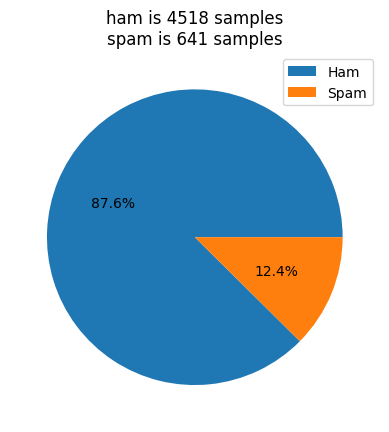

In [ ]:
fig, ax =  plt.subplots()
ax.pie(df.Class.value_counts().values, autopct = '%.1f%%')
ax.legend(["Ham","Spam"])
plt.title(f"{df.Class.value_counts().index[0]} is {df.Class.value_counts().values[0]} samples\n{df.Class.value_counts().index[1]} is {df.Class.value_counts().values[1]} samples")
fig.show()

In [ ]:
nltk.download('stopwords')
sw = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
stop_words = list(set(sw))
def remove_stopwords(text):
    text = ' '.join([word for word in text.lower().split() if word not in stop_words])
    return text

In [ ]:
df['Message_Trim'] = [remove_stopwords(Text) for Text in df['Message']]

In [ ]:
def form_worldcloud_string(df, column):
    string = " ".join(df[column].values.tolist())
    words = [text.capitalize() for text in string.split() if len(text) > 2]
    string = " ".join(words)
    return string

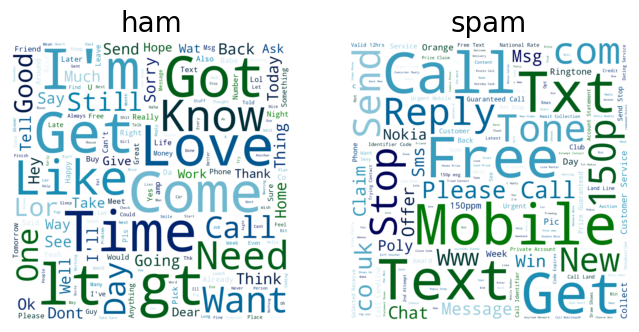

In [ ]:
n_col = int(np.ceil(np.sqrt(len(labels))))
n_row = int(np.ceil(len(labels) / n_col))

fig, axes = plt.subplots(n_row, n_col, figsize=(4 * n_col, 4 * n_row))

for ax in axes.flatten():
    ax.axis("off")

for i, (ax, label) in enumerate(zip(axes.flatten(), labels)):
    str_return =form_worldcloud_string(
        df.loc[df["Class"] == label, :],
        "Message_Trim",
    )

    # Generate a WordCloud image
    wc = WordCloud(
        width=1000,
        height=1000,
        colormap="ocean",
        background_color="white",
        min_font_size=10,
        max_font_size=200,
        max_words=200,
        stopwords=stop_words,
        relative_scaling=0,
        random_state=42,
        margin=20,
    )
    wc.generate(str_return)

    # Show WordCloud image
    ax.imshow(wc, interpolation="bilinear")
    ax.set_title(label, fontsize=20, color="black")

plt.show()

In [ ]:
tokenizer = Tokenizer(oov_token='<00U00>')

In [ ]:
tokenizer.fit_on_texts(df['Message_Trim'])
sequneces = tokenizer.texts_to_sequences(df['Message_Trim'])
matrix = pad_sequences(sequneces,
                       padding='post',
                       truncating='post',
                       maxlen=16)

In [ ]:
class_dict = {'ham':0,'spam':1}
encoded_label = np.array([class_dict[i] for i in df.Class],dtype='int32')

In [ ]:
model = Sequential([Embedding(len(tokenizer.word_index)+1,2),
                    GlobalMaxPooling1D(),
                    Dense(128, activation="relu"),
                    Dropout(0.5),
                    Dense(64, activation="relu"),
                    Dropout(0.5),
                    Dense(32, activation="relu"),
                    Dense(1,activation='sigmoid')])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(matrix, encoded_label, test_size=0.25, random_state=64,shuffle = True)

In [ ]:
history = model.fit(X_train, y_train, validation_data = (X_test, y_test),
                    epochs=64, batch_size=64,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/64
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8557 - loss: 0.5787 - val_accuracy: 0.8814 - val_loss: 0.2865 - learning_rate: 0.0010
Epoch 2/64
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8726 - loss: 0.2901 - val_accuracy: 0.8814 - val_loss: 0.2586 - learning_rate: 0.0010
Epoch 3/64
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8744 - loss: 0.2639 - val_accuracy: 0.8814 - val_loss: 0.2477 - learning_rate: 0.0010
Epoch 4/64
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8703 - loss: 0.2589 - val_accuracy: 0.8814 - val_loss: 0.2418 - learning_rate: 0.0010
Epoch 5/64
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9071 - loss: 0.2222 - val_accuracy: 0.9333 - val_loss: 0.2309 - learning_rate: 0.0010
Epoch 6/64
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9449 - loss: 0.2351 - val_accuracy: 0.9442 - val_loss: 0.2167 - learning_rate: 0.0010
Epoch 7/64
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9608 - loss: 0.1906 - val_accuracy: 

<Axes: >

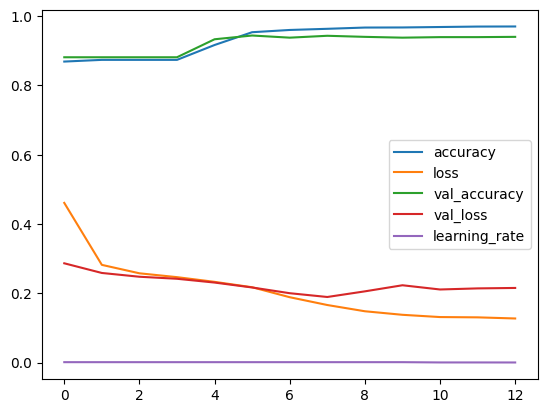

In [ ]:
df2=pd.DataFrame(model.history.history)
df2.plot()

In [ ]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Confusion Matrix = 
 [[1122   14]
 [  60   94]] 



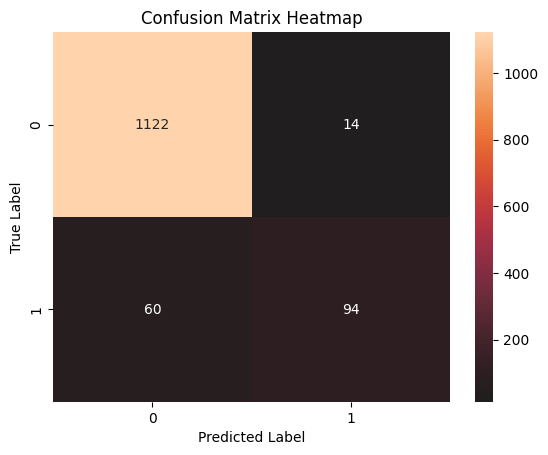

In [ ]:
CM=confusion_matrix(y_test,y_pred)
# Assuming CM is your confusion matrix
print("Confusion Matrix = \n", CM, "\n")


# Create the heatmap
sns.heatmap(CM, annot=True, fmt='d', center=0, cbar=True)

# Add labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')

# Show the plot
plt.show()